# Dictionary learning

In [1]:
import numpy as np 
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# Subroutines for first subproblem

def grad(Y, D, X): 
    return - Y @ X.T + D @ X @ X.T

def proj(D):

    return np.apply_along_axis(lambda d: d/np.max([1, np.linalg.norm(d)]), axis=0, arr=D)

def projected_gradient(Y, D, X, LR = 0.001, T = 100):
    for _ in range(T):
        D = proj ( D - LR * grad(Y,D,X))
    return D

In [3]:
# Subroutines for second subproblem

def ortho_match_pursuit(y, A, max_iter = 10, eps = 1e-2):
    S = []

    x = np.zeros(A.shape[1])
    iters = 0
    rate = 0
    R = y

    while iters < max_iter or rate > eps:

        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        S.append(np.argmax(np.abs(A.T @ R)))

        # Expand the dictionary for the representation
        dic = A[:,S]

        # Solve subproblems and update x
        x[S] = np.linalg.inv(dic.T @ dic) @ dic.T @ y
        
        # Update the residuals
        R = y - A @ x
        iters += 1

    return x


In [4]:
def SCADictionaryLearning(Y, m, epsilon = 1e-5, gamma = 0.99, max_iter = 200):
    s = Y.shape[0]
    t = Y.shape[1]

    D = np.random.rand(s,m)
    X = np.random.rand(m,t)

    '''
    for j in range(t):
        X[:,j] = Hs(X[:,j], k)
    '''
    # Normalize data
    Y = np.apply_along_axis(lambda x: x/np.linalg.norm(x), axis=0, arr=Y)
    
    loss = [np.linalg.norm(Y - D @ X)]
    rate = 1

    for it in tqdm(range(1,max_iter)): 
        if rate < epsilon:
            break

        D_hat = np.random.rand(D.shape[0],D.shape[1])
        X_hat = np.random.rand(X.shape[0],X.shape[1])

        # First subproblem - Normalized LS in the dictionary
        D_hat = projected_gradient(Y, D_hat, X)

        # Second subproblem - LASSO within each sample of signals

        for j in range(t): 
            X_hat[:,j] = ortho_match_pursuit(Y[:,j], D)

        # Convex combination
        
        D = D + gamma * (D_hat - D)
        X = X + gamma * (X_hat - X)

        # Decreasing step size 

        gamma *= 0.9
        
        '''
        D = D_hat
        X = X_hat
        '''
        
        # Metrics stores and update
        loss.append(np.linalg.norm(Y - D @ X))
        rate = np.abs(loss[it] - loss[it - 1])
        
    return D, X, loss

In [13]:
Y = np.random.rand(50,100)
Y += np.random.rand(50,100) * 0.01

In [14]:
D, X, loss = SCADictionaryLearning(Y, 100)

 53%|█████▎    | 106/199 [00:34<00:29,  3.10it/s]


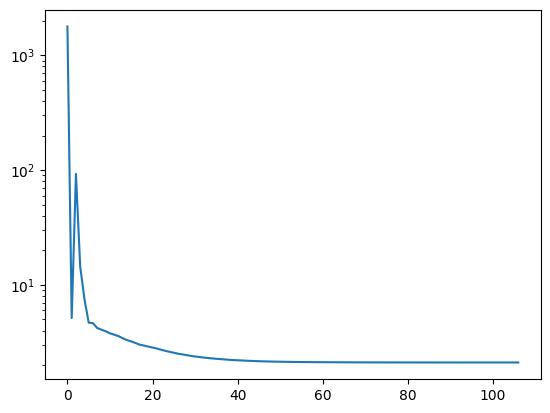

In [15]:
plt.plot(loss)
plt.yscale('log')